# Good Film // Bad Film
## Film Plot Synopses and etc. as Predictors of Critical Reception

This notebook builds and evaluates a handful of regression models which predict critical reception scores for films. Independent variables include plot synopsis free text, social media metrics on the leading actors, and other categorical variables such as film genre.

In [216]:
import os
import time
import pickle

import requests
from pycountry import languages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Data Collection

## Kaggle Dataset

From https://www.kaggle.com/tmdb/tmdb-movie-metadata:

In [217]:
kaggle_data = pd.read_csv('../data/imdb_5000_movies.csv') # Just a big Kaggle dataset full of movies.

In [218]:
kaggle_data.shape

(5043, 28)

## Extra Metadata from TheMovieDB.org

One good thing about this dataset is that it provides the unique IMdB movie ID's, which we can pass to a third-party API in order to supplement our data with more features. Here we parse out those IMdB ID's:

In [219]:
kaggle_data.tail()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
5038,Color,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,...,6.0,English,Canada,NaN,NaN,2013.0,470.0,7.7,NaN,84
5039,Color,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,...,359.0,English,USA,TV-14,NaN,NaN,593.0,7.5,16.00,32000
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,...,3.0,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16
5041,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,...,9.0,English,USA,PG-13,NaN,2012.0,719.0,6.3,2.35,660
5042,Color,Jon Gunn,43.0,90.0,16.0,16.0,Brian Herzlinger,86.0,85222.0,Documentary,...,84.0,English,USA,PG,1100.0,2004.0,23.0,6.6,1.85,456


Grab IMdB ID numbers for each film and append to dataframe:

In [220]:
imdb_ids = kaggle_data['movie_imdb_link'].str[26:35]
imdb_ids[3000:3005]

3000    tt0271259
3001    tt0118901
3002    tt0815178
3003    tt1730687
3004    tt0399095
Name: movie_imdb_link, dtype: object

In [221]:
kaggle_data['imdb_ids'] = imdb_ids

Here we make the API calls, and persist our data to little .json files:

In [222]:
# You will need to enter your own API key in the API_KEY.py file (remove the .template suffix)
from API_KEY import API_KEY

try:
    os.mkdir('../data/movie_metadata')
except FileExistsError:
    pass

__This will make lots of API calls, be warned and use sparingly__, to avoid burning out your API key

In [223]:
# i=0; j=0; total=len(imdb_ids)

# for id in imdb_ids:
#     print(f"Downloading movie {i} of {total}...")
#     i+=1
#     query_string = f'https://api.themoviedb.org/3/movie/{id}?api_key={API_KEY}'
#     json = requests.get(query_string).text
#     if "could not be found" in json:
#         j+=1
#         print(f"{round(j/i, 2)}% of movies not found")
#         continue
#     f = open(f'../data/movie_metadata/movie_{id}.json', 'w+')
#     f.write(json)
#     f.close()

## Combine Kaggle Dataset and TheMovieDB API Responses

In [224]:
# tmdb_movies = pd.DataFrame()

# for filename in os.listdir(path='../data/movie_metadata/'):
#     if "movie" in filename:
#         this_movie = pd.read_json(f"../data/movie_metadata/{filename}", lines=True)
#         tmdb_movies = pd.concat([this_movie,tmdb_movies], axis=0)

# tmdb_movies = tmdb_movies.reset_index(drop=True)

In [225]:
# df_merged = tmdb_movies.merge(kaggle_data, 
#                               how='left',
#                               left_on='imdb_id',
#                               right_on='imdb_ids',
#                               suffixes=("_kaggle","_api"))

# Data Cleaning and EDA

## Keep only interesting columns

In [226]:
# df_merged.columns.tolist()

In [227]:
# desired_cols = ("duration adult budget_api budget_kaggle language original_language "
#                 "production_countries runtime spoken_languages color genres_api "
#                 "title movie_title original_title overview content_rating "
#                 "actor_1_facebook_likes actor_2_facebook_likes actor_3_facebook_likes "
#                 "director_facebook_likes cast_total_facebook_likes facenumber_in_poster "
#                 "aspect_ratio imdb_score revenue").split()

In [228]:
# df_lesscols = df_merged[desired_cols]
# df_lesscols.head()

In [229]:
# df_lesscols.to_pickle("../data/pickles/df_lesscols.pkl")

In [230]:
df_lesscols = pd.read_pickle("../data/pickles/df_lesscols.pkl")
df_lesscols.head(3)

,duration,adult,budget_api,budget_kaggle,language,original_language,production_countries,runtime,spoken_languages,color,...,content_rating,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,aspect_ratio,imdb_score,revenue
0,156.0,False,NaN,10951000,Korean,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",156.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Color,...,Not Rated,45.0,5.0,0.0,43.0,50,0.0,2.35,7.7,47098491
1,102.0,False,NaN,0,French,fr,"[{'iso_3166_1': 'FR', 'name': 'France'}]",102.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Color,...,NaN,541.0,8.0,2.0,12.0,553,2.0,NaN,7.2,0
2,100.0,False,3500000.0,3500000,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Color,...,NaN,21.0,3.0,0.0,117.0,24,0.0,NaN,7.0,0


## Null Values Management

Here are all of the truly "null" values:

[]

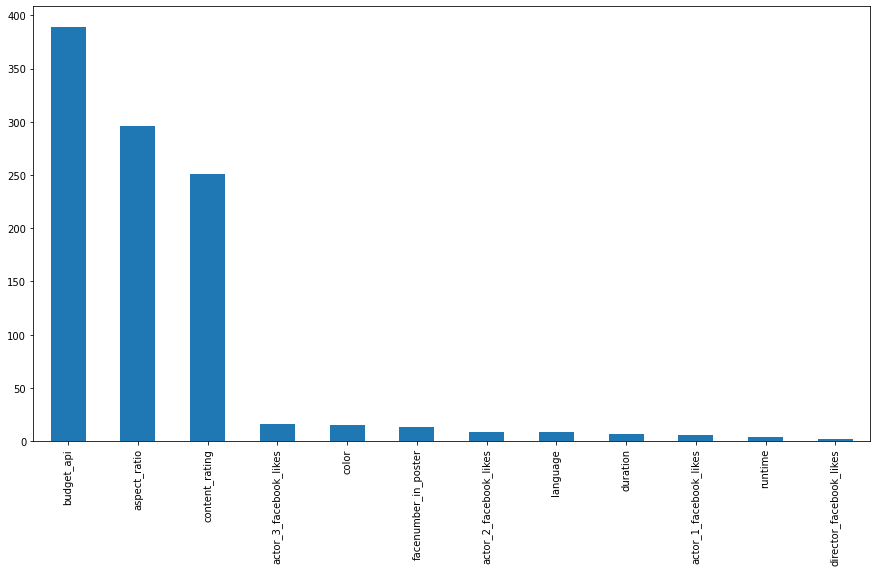

In [231]:
nulls = df_lesscols.isna().sum()[df_lesscols.isna().sum() > 0].sort_values(ascending=False)

nulls.plot(kind='bar', figsize=(15,8)).plot()

Gotta start somewhere.

### Budget

We have two disparate budget columns to draw from. We want whatever seems most plausible.

In [232]:
df_lesscols[["budget_api", "budget_kaggle"]].head(10)

,budget_api,budget_kaggle
0,NaN,10951000
1,NaN,0
2,3500000.0,3500000
3,12620000.0,12700000
4,5000000.0,0
5,5000000.0,5000000
6,4900000.0,4900000
7,990000.0,0
8,168000.0,0
9,2000000.0,0


Lots of nulls in budget_api, lots of zeroes in budget_kaggle. How best to handle this? And are there other columns where we just have a bunch of zero values instead of nulls (revenue??)

In [233]:
def best_guess_budget(row):
    # When budget_api is NaN and budget_kaggle is non-zero, take budget_kaggle.
    if row.isna()["budget_api"] and row['budget_kaggle'] != 0:
        return row['budget_kaggle']
    
    # When budget_api is not NaN but budget_kaggle is zero, take budget_api.
    elif not row.isna()["budget_api"] and row['budget_kaggle'] == 0:
        return row['budget_api']
    
    # When both values are not NaN / non-zero, take the mean?
    elif not row.isna()["budget_api"] and row['budget_kaggle'] != 0:
        return np.mean((row['budget_kaggle'], row['budget_api']))
        
    # When budget_api is NaN AND budget_kaggle is zero...that's tough. Maybe drop row. Consider imputing values?
    else:
        return None

In [234]:
df_lesscols.head(10).apply(best_guess_budget, axis=1)

0    10951000.0
1           NaN
2     3500000.0
3    12660000.0
4     5000000.0
5     5000000.0
6     4900000.0
7      990000.0
8      168000.0
9     2000000.0
dtype: float64

This is the desired behavior.

In [235]:
best_budget = df_lesscols.apply(best_guess_budget, axis=1)

In [236]:
df_best_guess_budget = df_lesscols.assign(best_budget=best_budget
                                         ).drop("budget_api budget_kaggle".split(), axis=1)

In [237]:
df_best_guess_budget.best_budget.isna().mean()

0.0550253807106599

5% of budget values are missing. I think I will in fact impute the median.

In [238]:
budget_med = df_best_guess_budget.best_budget.dropna().median()
budget_mean = df_best_guess_budget.best_budget.dropna().mean()
budget_med, budget_mean

(19500000.0, 37180395.97410829)

In [239]:
df_filled_budget = df_best_guess_budget.assign(
    filled_budget = df_best_guess_budget["best_budget"].fillna(budget_med)
).drop(["best_budget"],axis=1)

In [240]:
df_filled_budget.filled_budget.isna().mean()

0.0

In [241]:
df_filled_budget.filled_budget.median(), df_filled_budget.filled_budget.mean()

(19500000.0, 36207525.45451777)

This doesn't seem to have shifted the mean much, that's good.

### Aspect Ratio

In [242]:
df_filled_budget.aspect_ratio.isna().mean()

0.060101522842639594

6% of aspect ratios are null.

This is a categorical describing the dimensions of the projected image. Your TV set is 16x9 aka 1.77 aspect ratio, whereas lots of hollywood films are 1.85 ratio or 2.40, much "wider-screen". 2.40 might be "artsier".

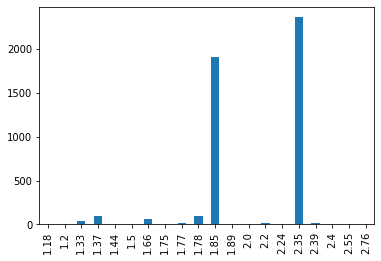

In [243]:
# Aspect ratio of 16 I take to mean 16x9 aka 1.77:
df_filled_budget.aspect_ratio = df_filled_budget.aspect_ratio.apply(lambda x: 1.77 if x==16 else x)
df_filled_budget.aspect_ratio.value_counts().sort_index().plot(kind="bar")

I think I will lump some of these together and impute 1.85 on null values. It's not *quite* the mode but it's a sort of middle-of-the road aspect ratio. The DCI standard lists 2.39 and 1.85 for theatrical projection. 16x9 or 1.77 is also common, and 4/3 or 1.33 is like an old-timey boxey aspect ratio.

In [244]:
aspect_bins = [0, np.mean((1.33, 1.77)), np.mean((1.77,1.85)), np.mean((1.85,2.39)), np.inf]
aspect_labels = "1.33 1.77 1.85 2.39".split()

In [245]:
pd.cut(df_filled_budget.aspect_ratio, 
       bins=aspect_bins, 
       labels=aspect_labels,
       include_lowest=True)

0       2.39
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
4920    1.33
4921    1.33
4922    1.33
4923    1.33
4924    1.33
Name: aspect_ratio, Length: 4925, dtype: category
Categories (4, object): [1.33 < 1.77 < 1.85 < 2.39]

Lump values and impute 1.85:

In [246]:
df_fixed_aspect = df_filled_budget.assign(fixed_aspect = pd.cut(df_filled_budget.aspect_ratio, 
                                                         bins=aspect_bins, 
                                                         labels=aspect_labels,
                                                         include_lowest=True
                                                               ).fillna("1.85")
                                         ).drop(["aspect_ratio"],axis=1)

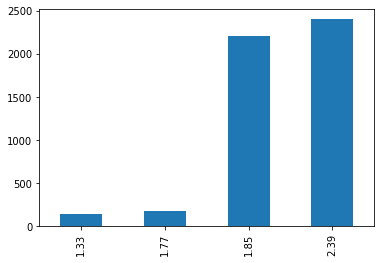

In [247]:
df_fixed_aspect.fixed_aspect.value_counts().sort_index().plot(kind="bar")

### Content Rating

In [248]:
df_fixed_aspect.content_rating.isna().mean()

0.05096446700507614

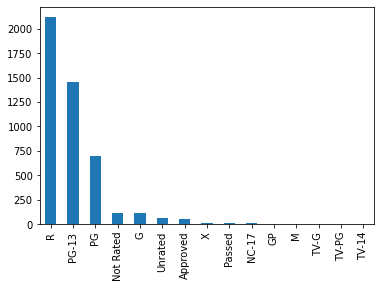

In [249]:
df_fixed_aspect.content_rating.value_counts().plot(kind="bar")

Just gonna fill nulls with PG-13 and condense redundant ones

In [250]:
df_content_rating_filled = df_fixed_aspect.assign(
                                content_rating=df_fixed_aspect.content_rating.fillna("PG-13")
                           )

In [251]:
def rating_mapper(rating):
    if rating == "Not Rated":
        return "Unrated"
    elif rating in "Approved Passed M TV-14".split():
        return "PG-13"
    elif rating in "TV-G GP G TV-PG".split():
        return "PG"
    elif rating in ["NC-17"]:
        return "X"
    else:
        return rating

In [252]:
df_content_rating_condensed = df_content_rating_filled.assign(
                                content_rating = df_content_rating_filled.content_rating.map(rating_mapper)
                              )

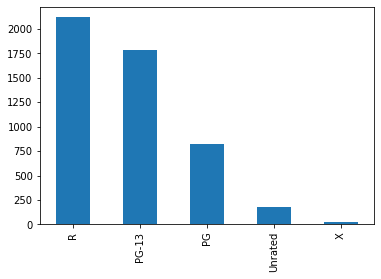

In [253]:
df_content_rating_condensed.content_rating.value_counts().plot(kind="bar")

In [254]:
df_content_rating_condensed.content_rating.isna().mean()

0.0

How are we doing on null values globally?

[]

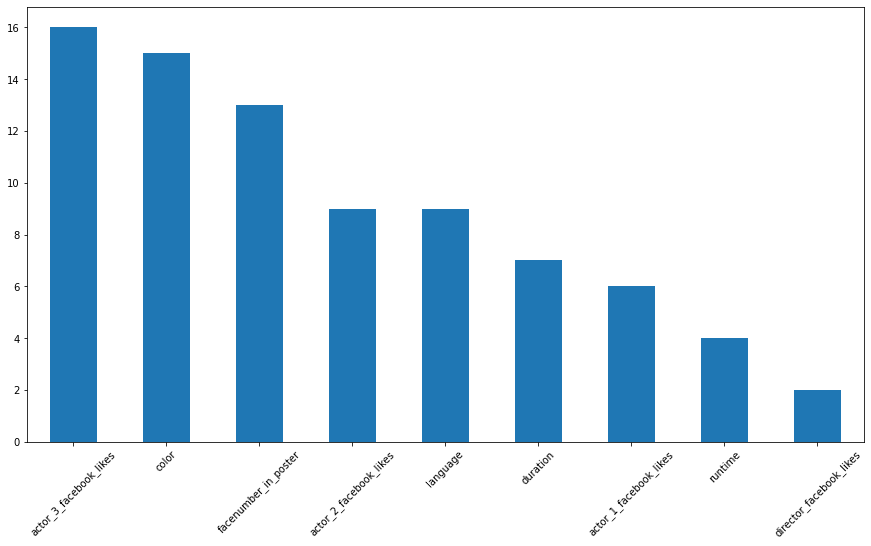

In [255]:
nulls_update = df_content_rating_condensed.isna().sum()[
    df_content_rating_condensed.isna().sum() > 0
].sort_values(ascending=False)

nulls_update.plot(kind='bar', figsize=(15,8), rot=45).plot()

Clearing some memory:

In [256]:
# del nulls
# del imdb_ids
# del best_budget
# del kaggle_data
del df_lesscols
del df_best_guess_budget
del df_filled_budget
del df_content_rating_filled
del df_fixed_aspect

### Facebook Like Counts

In [257]:
facebook_like_cols = [col for col in df_content_rating_condensed if "facebook" in col]
likes = df_content_rating_condensed[facebook_like_cols]

df_content_rating_condensed.drop(facebook_like_cols, axis=1, inplace=True)

likes.head()

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes
0,45.0,5.0,0.0,43.0,50
1,541.0,8.0,2.0,12.0,553
2,21.0,3.0,0.0,117.0,24
3,14000.0,81.0,29.0,32.0,14133
4,927.0,509.0,503.0,23.0,3552


In [258]:
(round(likes.isna().mean()*100,2)).sort_values(ascending=False).astype('str')+"%"

actor_3_facebook_likes       0.32%
actor_2_facebook_likes       0.18%
actor_1_facebook_likes       0.12%
director_facebook_likes      0.04%
cast_total_facebook_likes     0.0%
dtype: object

Not that many values are missing. Will just use the medians.

In [259]:
likes.fillna({col:likes[col].median() for col in likes.columns}, inplace=True)

/Users/admin/.local/share/virtualenvs/Good-Film-Bad-Film-vaMlpeB4/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [260]:
df_likes_filled = pd.concat([df_content_rating_condensed,
                             likes], axis=1)

In [261]:
del df_content_rating_condensed
del likes

Time for another check-in:

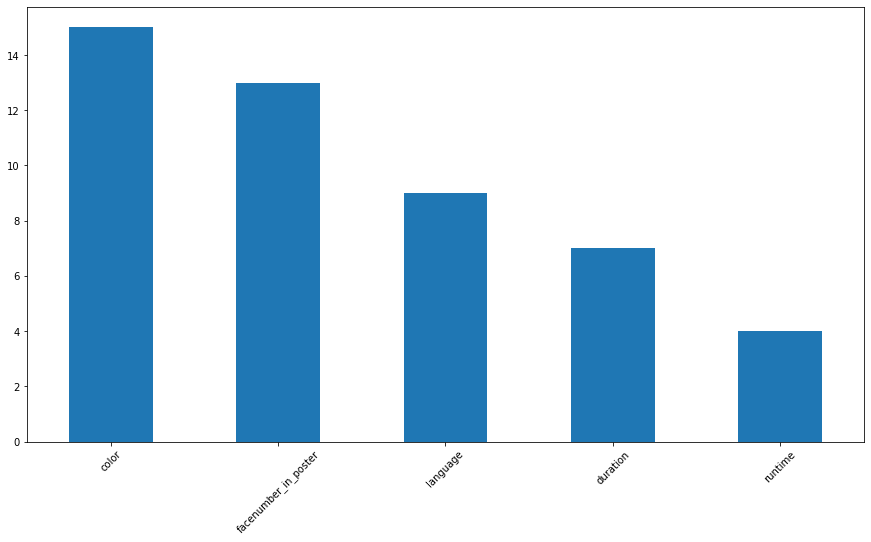

In [262]:
nulls_update = df_likes_filled.isna().sum()[
    df_likes_filled.isna().sum() > 0
].sort_values(ascending=False)

nulls_update.plot(kind='bar', figsize=(15,8), rot=45).plot()

del nulls_update

### Color

In [263]:
df_likes_filled.color = df_likes_filled.color.str.lstrip()
df_likes_filled.color.value_counts()

Color              4704
Black and White     206
Name: color, dtype: int64

Seems safe to assume that the last dozen films are in color...

In [264]:
df_likes_filled.color = df_likes_filled.color.fillna(df_likes_filled.color.mode())
df_color_filled = df_likes_filled.copy()

In [265]:
del df_likes_filled

In [266]:
df_color_filled.head(3)

,duration,adult,language,original_language,production_countries,runtime,spoken_languages,color,genres_api,title,...,facenumber_in_poster,imdb_score,revenue,filled_budget,fixed_aspect,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes
0,156.0,False,Korean,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",156.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Color,Fantasy|Horror|Mystery|Thriller,The Wailing,...,0.0,7.7,47098491,10951000.0,2.39,45.0,5.0,0.0,43.0,50
1,102.0,False,French,fr,"[{'iso_3166_1': 'FR', 'name': 'France'}]",102.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Color,Comedy|Drama,The Country Doctor,...,2.0,7.2,0,19500000.0,1.85,541.0,8.0,2.0,12.0,553
2,100.0,False,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Color,Documentary,Time to Choose,...,0.0,7.0,0,3500000.0,1.85,21.0,3.0,0.0,117.0,24


### Face Number in Poster

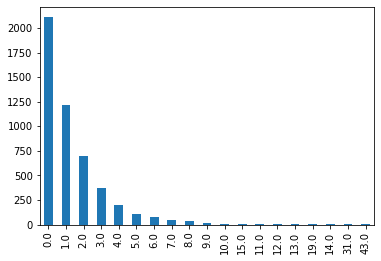

In [267]:
df_color_filled.facenumber_in_poster.value_counts().plot(kind='bar')

Zero seems to be a placeholder for "idk" in this dataset, I'll drop this column.

In [268]:
df_no_facenums = df_color_filled.drop(['facenumber_in_poster'],axis=1)
del df_color_filled
df_no_facenums.head()

,duration,adult,language,original_language,production_countries,runtime,spoken_languages,color,genres_api,title,...,content_rating,imdb_score,revenue,filled_budget,fixed_aspect,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes
0,156.0,False,Korean,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",156.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Color,Fantasy|Horror|Mystery|Thriller,The Wailing,...,Unrated,7.7,47098491,10951000.0,2.39,45.0,5.0,0.0,43.0,50
1,102.0,False,French,fr,"[{'iso_3166_1': 'FR', 'name': 'France'}]",102.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Color,Comedy|Drama,The Country Doctor,...,PG-13,7.2,0,19500000.0,1.85,541.0,8.0,2.0,12.0,553
2,100.0,False,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Color,Documentary,Time to Choose,...,PG-13,7.0,0,3500000.0,1.85,21.0,3.0,0.0,117.0,24
3,115.0,False,English,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",111.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Color,Action|Drama|History|War,Operation Chromite,...,PG-13,6.8,49196532,12660000.0,1.85,14000.0,81.0,29.0,32.0,14133
4,96.0,False,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Color,Comedy|Romance,The Perfect Match,...,R,4.5,0,5000000.0,1.85,927.0,509.0,503.0,23.0,3552


### Language

In [269]:
langs = df_no_facenums[[col for col in df_no_facenums.columns if "language" in col]]
langs.head(15)

,language,original_language,spoken_languages
0,Korean,ko,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso..."
1,French,fr,"[{'iso_639_1': 'fr', 'name': 'Français'}]"
2,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
3,English,ko,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso..."
4,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
5,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
6,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
7,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
8,Romanian,ro,"[{'iso_639_1': 'ro', 'name': 'Română'}]"
9,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"


In [270]:
langs.isna().mean()

language             0.001827
original_language    0.000000
spoken_languages     0.000000
dtype: float64

In [271]:
df_no_facenums.loc[13]

duration                                                                   119
adult                                                                    False
language                                                               English
original_language                                                           zh
production_countries         [{'iso_3166_1': 'HK', 'name': 'Hong Kong'}, {'...
runtime                                                                    120
spoken_languages                          [{'iso_639_1': 'zh', 'name': '普通话'}]
color                                                                    Color
genres_api                                            Action|Adventure|Fantasy
title                                                        The Monkey King 2
movie_title                       Xi you ji zhi: Sun Wukong san da Baigu Jing 
original_title                                                    西游记之孙悟空三打白骨精
overview                     Taking place 500 years 

The "language" column looks not great. "original language" is probably a better bet.

In [272]:
df_no_facenums.spoken_languages.tail()

4920    [{'iso_639_1': 'xx', 'name': 'No Language'}]
4921    [{'iso_639_1': 'xx', 'name': 'No Language'}]
4922    [{'iso_639_1': 'xx', 'name': 'No Language'}]
4923    [{'iso_639_1': 'xx', 'name': 'No Language'}]
4924    [{'iso_639_1': 'xx', 'name': 'No Language'}]
Name: spoken_languages, dtype: object

In [273]:
df_no_facenums.original_language.tail()

4920    de
4921    de
4922    en
4923    en
4924    en
Name: original_language, dtype: object

Yeah I think that's probably the best column.

In [274]:
df_no_facenums.original_language.value_counts().head(10)

en    4602
fr      74
es      34
zh      29
hi      29
de      27
ja      17
cn      14
ko      12
it      11
Name: original_language, dtype: int64

Using a python package to make language codes human-readable:

In [276]:
lang_decoder = {lang.alpha_2: lang.name for lang in languages if hasattr(lang,'alpha_2')}
list(lang_decoder.items())[:5]

[('aa', 'Afar'),
 ('ab', 'Abkhazian'),
 ('af', 'Afrikaans'),
 ('ak', 'Akan'),
 ('am', 'Amharic')]

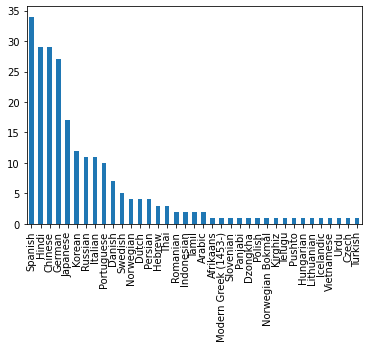

In [277]:
df_no_facenums.original_language = df_no_facenums.original_language.map(lang_decoder)
df_no_facenums.original_language.value_counts()[2:].plot(kind='bar')

Just eyeballing it...I think anything after German, in terms of frequency, is gonna have to go in "other"

Grabbing most popular languages:

In [279]:
top_langs = df_no_facenums.original_language.value_counts().index[:6].tolist()
top_langs

['English', 'French', 'Spanish', 'Hindi', 'Chinese', 'German']

In [280]:
def language_lumper(lang):
    if lang not in top_langs:
        return "Other"
    else:
        return lang

In [281]:
df_no_facenums.original_language = df_no_facenums.original_language.apply(language_lumper)

In [284]:
df_langs_lumped = df_no_facenums.drop("language spoken_languages".split(),axis=1)

In [286]:
del df_no_facenums
del country_decoder
del langs

In [285]:
df_langs_lumped.head()

,duration,adult,original_language,production_countries,runtime,color,genres_api,title,movie_title,original_title,...,content_rating,imdb_score,revenue,filled_budget,fixed_aspect,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes
0,156.0,False,Other,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",156.0,Color,Fantasy|Horror|Mystery|Thriller,The Wailing,The Wailing,곡성,...,Unrated,7.7,47098491,10951000.0,2.39,45.0,5.0,0.0,43.0,50
1,102.0,False,French,"[{'iso_3166_1': 'FR', 'name': 'France'}]",102.0,Color,Comedy|Drama,The Country Doctor,Irreplaceable,Médecin de campagne,...,PG-13,7.2,0,19500000.0,1.85,541.0,8.0,2.0,12.0,553
2,100.0,False,English,"[{'iso_3166_1': 'US', 'name': 'United States o...",100.0,Color,Documentary,Time to Choose,Time to Choose,Time to Choose,...,PG-13,7.0,0,3500000.0,1.85,21.0,3.0,0.0,117.0,24
3,115.0,False,Other,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",111.0,Color,Action|Drama|History|War,Operation Chromite,Operation Chromite,인천상륙작전,...,PG-13,6.8,49196532,12660000.0,1.85,14000.0,81.0,29.0,32.0,14133
4,96.0,False,English,"[{'iso_3166_1': 'US', 'name': 'United States o...",96.0,Color,Comedy|Romance,The Perfect Match,The Perfect Match,The Perfect Match,...,R,4.5,0,5000000.0,1.85,927.0,509.0,503.0,23.0,3552


## Clustering Redundant Values and further cleanup

## Distribution Checks

***

In [ ]:
df = df[~((df['Plot'] == 'N/A')|(df['imdbRating'] == 'N/A'))] # Drops movies with null plots
df.imdbRating = df.imdbRating.astype(float)
df['binary_target'] = df['imdbRating'] >= df['imdbRating'].mean()   #binary target column. True = above mean ; False = below mean
df['binary_target'] = df['binary_target'].astype(int)
df['Actor_1_fb_likes'].fillna((df['Actor_1_fb_likes'].mean()), inplace=True)
df['Actor_2_fb_likes'].fillna((df['Actor_2_fb_likes'].mean()), inplace=True)
df['Actor_3_fb_likes'].fillna((df['Actor_3_fb_likes'].mean()), inplace=True)

In [ ]:
df = df.reset_index()
df = df.drop(['index'], axis=1)
df[:3]

### One-hot encoding Genres

In [ ]:
final_genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Sport', 'Thriller', 'War', 'Western']    

#create a list of lists, where each element is a list of a movie's classified genres
li = []
[li.append(df.iloc[i]['Genre'].split(', ')) for i in range(len(df))]

#adding columns to df for each genre, 1 represents the movie is classified under that genre, 0 is that it is not
for genre in final_genres:
    list = []
    [list.append(1) if genre in movie
    else list.append(0) for movie in li]
    df[genre] = list

### Creating a fresh DataFrame with everything but Plot Text Features

In [ ]:
main_df = pd.DataFrame()

#join the features we want to narrow in on with our target variable
genres = df.iloc[:,-21:]
main_df['Year'] = [int(year.split('–')[0]) for year in df['Year'].values]
main_df = main_df.join(genres)

main_df[:3]

In [ ]:
main_df.columns

In [ ]:
main_df.Year.hist()

In [ ]:
main_df.binary_target.hist()

### Log Transforming "Actor Facebook Likes"

'Actor_1_fb_likes' had some striking outliers and needed a log transform:

In [ ]:
df.Actor_1_fb_likes.hist() # Check out those outliers. Can't even see them...

In [ ]:
def log_transform_col(feature, dataframe):
    logged = pd.Series(np.log(dataframe[feature].values+1), name=feature+'_logged')
    return logged

actor_features = ['Actor_1_fb_likes', 'Actor_2_fb_likes','Actor_3_fb_likes']

actor_likes = [log_transform_col(actor_features[i], df) for i in range(len(actor_features))]

In [ ]:
pd.Series(actor_likes).hist() # Much better

Looks way more gaussian after a log transform. We add these logged features to our dataframe:

In [ ]:
main_df = main_df.join(actor_likes)
main_df[:3]

### Baseline Logistic Regression without Plot-Text Features

Now that we've cleaned up a bit, we'll start throwing our features at a statsmodels logistic regression estimator to evaluate r^2 and p-values of various features.

In [ ]:
# check LogReg with all initial variables from main_df (note: no plot)
s = ("binary_target ~ Year + C(Action) + C(Adventure) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Crime) + C(Documentary) + C(Drama) + C(Family) + C(Fantasy) + C(History)"
                 "+ C(Horror) + C(Musical) + C(Mystery) + C(Romance) + C(Sci_Fi) + C(Sport)"
                 "+ C(Thriller) + C(War)+ C(Western)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

y, X = dmatrices(s, main_df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

This gives us an idea of which features might be less important in the determination of what makes a movie "good". We'll drop the less pertinent features and try again:

In [ ]:
s = ("binary_target ~ Year + C(Action) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Documentary) + C(Drama) + C(Family)"
                 "+ C(Horror) + C(Mystery) + C(Romance) + C(Sci_Fi)"
                 "+ C(Thriller)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

main_df = main_df.drop(['Adventure','Crime', 'Fantasy', 'History', 'Musical', 'Sport', 'War', 'Western'], axis=1)

y, X = dmatrices(s, main_df, return_type = "dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

In [ ]:
main_df.columns

These are the features we're sticking with for now.

### Correlation Matrices

We'd be remiss not to check for overly correlated features:

In [ ]:
# Creating a multi-scatter plot
main_corr= main_df.drop(['binary_target'], axis=1).iloc[:,:]
pd.plotting.scatter_matrix(main_corr, figsize=[15,15]);

In [ ]:
sns.heatmap(main_corr.corr(), center=0);

It's fairly intuitive that the social media popularity of the leading actors would be positively correlated, but we'll leave it in in case there are deviations from that norm. It's interesting to note that films in the "animation" genre are so commonly also in the "family" genre. Makes sense too.

## Using NLP to get features from the Plot Synopses

#### Setting up Lemmatization / Normalization Functions:

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def lemmatize(plot_list):
    lemmatized_plots = []
    
    for plot in plot_list:
        tokenized_lower = word_tokenize(plot.lower()) # Make plot summary lowercase and lemmatize        
        tokenized_lower =[word for word in tokenized_lower if english_d.check(word)] # Make sure it's an english word
        dirty_lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokenized_lower] # Lemmatize
        dirty_lemma_string = ' '.join(dirty_lemma)
        
        # Filter out words that don't match this regex pattern:
        reg = re.compile((r"([a-zA-Z]+(?:'[a-z]+)?)"))
        lemmatized_regex = [word_lem for word_lem in dirty_lemma if word_lem in reg.findall(dirty_lemma_string)]
        
        # Remove stop words
        lemmatized = [word_lem for word_lem in lemmatized_regex if not word_lem in stop_words]
        lemmatized_string = ' '.join(lemmatized)
        lemmatized_plots.append(lemmatized_string)
        
    return lemmatized_plots

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to the first character that lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

### Run the Lemmatizer

In [ ]:
all_plots = [plot for plot in df.loc[:,'Plot'].values] # Get all movie plots.
plots = lemmatize(all_plots) # Lemmatize.

### Vectorizing Plots

In [ ]:
# Term frequency = Number of times a word appears in a document / number of words in document
# Inverse document frequency = log base e(number of documents / number of documents with word in it)
# tf:idf = tf * idf

tfidf = TfidfVectorizer()
response = tfidf.fit_transform(plots)
print(response.shape)

tfidf_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

Now we have all plots lemmatized as "plots" and vectorized / weighted as "tfidf_df".

### Incorporating some LDA; Clustering Documents by Topic

Gensim clusters words that appear together frequently. The clusters can be interpreted as general topics, and each movie gets weights indicating the degree to which it belongs to each topic. These weights are then re-incorporated as features in our dataset.

In [ ]:
all_words = [plot.split(' ') for plot in plots] # Just formatting our corpus how Gensim wants it

In [ ]:
dictionary = corpora.Dictionary(all_words)
corpus = [dictionary.doc2bow(text) for text in all_words]
pickle.dump(corpus, open('pickles/corpus.pkl', 'wb'))
dictionary.save('pickles/dictionary.gensim')

In [ ]:
NUM_TOPICS = 50 # This value was arbitrarily chosen.
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10) # Also arb
ldamodel.save('pickles/model5.gensim')

In [ ]:
topics = ldamodel.print_topics(num_words=4)
topics # These are examples of some of the clusters created by Gensim.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

In [ ]:
tm = pd.DataFrame()
for i in range(len(corpus)):
    new_row = np.zeros(NUM_TOPICS)
    for toop in ldamodel.get_document_topics(corpus[i]): # These two lines are where you do what you need to do
        new_row[toop[0]] = toop[1]                       # to flip zeroes to ones if the genre appears
    tm = tm.append(pd.Series(new_row), ignore_index=1)

In [ ]:
tm.head() # This is a DataFrame with the weights from the GenSim clustering.

## Joining Topic-Modeled Synopses with Standard Features

In [ ]:
df = main_df.join(tm)
len(df.columns)

## Model Building

In [ ]:
X = df.drop(['binary_target'], axis=1)
y = df.binary_target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

train_test_split on X_scaled:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size =  0.2)

### Baselining:

In [ ]:
dc = DummyClassifier().fit(X_train, y_train)

In [ ]:
accuracy_score(y_test,dc.predict(X_test))

Dimensionality Reduction with SVD - For the PlotText Data:

In [ ]:
svd = TruncatedSVD(n_components=50, n_iter=3, random_state=42)
X_train_pca = pd.DataFrame(svd.fit_transform(X_train))
print(svd.explained_variance_ratio_.sum())

Next we'll try a simple Gaussian Naive Bayes Model:

In [ ]:
clf = GaussianNB()
clf.fit(X_train_pca, y_train)
y_preds = clf.predict(pd.DataFrame(svd.transform(X_test)))
print(metrics.classification_report(y_test, y_preds))
test_accuracy = accuracy_score(y_test,y_preds)
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

__________

Now we'll go nuts and try an XGBClassifier model. A boosted model seems to work better without PCA, so we'll drop it for this part.

In [ ]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)#pd.DataFrame(svd.transform(X_test)))

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

In [ ]:
y_score = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr, tpr)))

In [ ]:
def draw_roc_curve(fpr,tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
draw_roc_curve(fpr,tpr)

Looks like we're off to an okay start!

## Grid Searching for better parameters

In [ ]:
# svd_components = [100,500,1000]
# itera = [3, 5]

n_est = [50,80,100]
max_depth = [2,3,4]
learning_rates = [.08, .1, .15]

pipe = Pipeline([
#     ('reduce_dim', TruncatedSVD()),
    ('classify', XGBClassifier())
])

param_grid = [
    {
#         'reduce_dim__n_components': svd_components,
#         'reduce_dim__n_iter': itera,
        'classify__n_estimators': n_est,
        'classify__max_depth': max_depth,
        'classify__n_jobs': [-1],
        'classify__learning_rate': learning_rates
    }]

score = {'f1': 'f1', 
         'accuracy': 'accuracy'}

grid_adc = GridSearchCV(pipe, 
                        n_jobs=-1, 
                        param_grid=param_grid, 
                        scoring=score, 
                        refit='accuracy',
                        verbose=10)

grid_adc.fit(X_train, y_train)
grid_adc.best_params_

In [ ]:
# Check the gridsearch results:
y_preds = grid_adc.predict(X_test)
accuracy_score(y_test, y_preds)

In [ ]:
y_score = grid_adc.predict_proba(X_test)
fpr_gs, tpr_gs, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr_gs, tpr_gs)))

In [ ]:
plt.figure(0).clf()
plt.figure(figsize=(10,8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve XGBClassifier')
plt.plot(fpr_gs,tpr_gs,
         label='Grid Searched XGBClassifier')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.legend(loc=0)

Negligible improvement.